# Generating PMO Comparison Plots

The aim of this file is to produce the plots that incorporate both our results on a certain benchmark, as well as the benchmarks for other methods from the PMO benchmark.

## Setup

### Change Working Directory

In [1]:
# Change working directory to the parent of the parent of the script

import os

# Get the current working directory
current_directory = os.getcwd()

# Get the parent of the parent directory
parent_parent_directory = os.path.abspath(os.path.join(current_directory, '..', '..'))

# Change the working directory to the parent of the parent directory
os.chdir(parent_parent_directory)

# Verify the change by printing the new working directory
print("New working directory:", os.getcwd())


New working directory: /vol/project/2023/70079/g237007905/bo_molecules


### Imports

In [2]:
# Standard library imports
import random
from typing import List


# Third-party imports
import gpytorch
import torch
import json
from tdc import Oracle
from gauche.kernels.graph_kernels import WeisfeilerLehmanKernel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from gauche import SIGP, NonTensorialInputs
from scipy.ndimage.filters import gaussian_filter1d

from botorch.fit import fit_gpytorch_mll, fit_gpytorch_mll
from botorch.settings import debug
from botorch.exceptions.errors import ModelFittingError

/vol/project/2023/70079/g237007905/bo_molecules/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Module Imports
from modules.benchmarking.metrics_and_benchmarking import accumulate_top_n
from modules.utils.read_sample_store import read_compressed_or_regular_json, buffer_to_dataframe

[04/27/24 17:36:01] WARNING  To use the Graphein submodule                                         ]8;id=700504;file:///vol/project/2023/70079/g237007905/bo_molecules/venv/lib/python3.10/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=800843;file:///vol/project/2023/70079/g237007905/bo_molecules/venv/lib/python3.10/site-packages/graphein/protein/features/sequence/embeddings.py#45\45]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             To do so, use the following command: pip install biovec                               
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

                    WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=466725;file:///vol/project/2023/70079/g237007905/bo_molecules/venv/lib/python3.10/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=578414;file:///vol/project/2023/70079/g237007905/bo_molecules/venv/lib/python3.10/site-packages/graphein/protein/visualisation.py#36\36]8;;\
                             need to install: pytorch3d                                                            
                             pytorch3d cannot be installed via pip                                                 

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=334158;file:///vol/project/2023/70079/g237007905/bo_molecules/venv/lib/python3.10/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=84177;file:///vol/project/2023/70079/g237007905/bo_molecules/venv/lib/python3.10/site-packages/graphein/protein/meshes.py#30\30]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: pip install pytorch3d                            

### Configurations

In [7]:
oracle_name = 'albuterol_similarity'

# Configurations for the plots
x_min = 0
x_max = 10_000
y_min = 0
y_max = 1.1

smoothing_sigma = 50  # Smoothing factor for the PMO plots

title = f"Best Observed Top 10 values for {oracle_name}"


# Configurations for our experiments
exp_start_iteration = 10
exp_buffer_path = f"experiments/results/{oracle_name}/2024-04-26_18-03-09_albuterol_similarity_1500/buffer.json.gz"


# Configurations for the PMO results 
pmo_start_iteration = 10      
n_pmo_iterations = 10_000
pmo_results_dir = f'experiments/pmo_benchmarking_comparison_plots/lines_from_graph_paper/{oracle_name}/'
pmo_results_map = {
    'GP BO': 'gp_bo.json',
    'Graph GA': 'graph_ga.json',
    'MolPAL': 'mol_pal.json',
    'REINVENT': 'reinvent.json'
}

### Utility Functions

In [5]:
def prepare_experiment_results(buffer_file_path: str, start_iteration: int) -> List[float]:
    """
    Load our results buffer and prepare data for plotting.

    Args:
        buffer_file_path: Path to the buffer file for the experiment.
        start_iteration: Start iteration for the plot. If > 0, pad the data with NaNs.

    Returns:
        List[float]: Data for the top 10 plot.
    """
    # Load the buffer file
    buffer = read_compressed_or_regular_json(buffer_file_path)

    # Convert the buffer to a DataFrame
    buffer_df = buffer_to_dataframe(buffer)

    # Calculate top 10 values
    data = accumulate_top_n(buffer_df['oracle_score'], 10)

    # Pad the data, if required
    data = [np.nan] * start_iteration + data

    return data


def prepare_pmo_results(json_path: str, smoothing_sigma: int, pmo_start_iteration: int) -> List[float]:
    """
    Load and prepare PMO data for plotting.

    Args:
        json_path: Path to the JSON file containing the PMO results.
        smoothing_sigma: Smoothing factor for the PMO plot.
        pmo_start_iteration: Start iteration for the PMO plot. PMO plots are
                already padded with NaNs. This helps to mask out the NaN while
                applying Gaussian smoothing. 

    Returns:
        List[float]: Data for the top 10 plot.
    """
    # Load values from the json file
    print(file_path)
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Separate out the NaNs before smoothing
    nan_data = data[:pmo_start_iteration]
    non_nan_data = data[pmo_start_iteration:]

    # Smoothing out PMO data points
    smoothed_data = gaussian_filter1d(non_nan_data, sigma=smoothing_sigma)

    # Merge back NaN values
    data = nan_data + smoothed_data.tolist()

    return data

def get_sns_colors() -> List[str]:
    """
    Get the colors from the seaborn color palette.

    Returns:
        List[str]: List of Hex codes in the seaborn color palette.
    """
    return sns.color_palette().as_hex()

### Generate Comparison Plots

experiments/pmo_benchmarking_comparison_plots/lines_from_graph_paper/zaleplon_mpo/gp_bo.json
experiments/pmo_benchmarking_comparison_plots/lines_from_graph_paper/zaleplon_mpo/graph_ga.json
experiments/pmo_benchmarking_comparison_plots/lines_from_graph_paper/zaleplon_mpo/mol_pal.json
experiments/pmo_benchmarking_comparison_plots/lines_from_graph_paper/zaleplon_mpo/reinvent.json


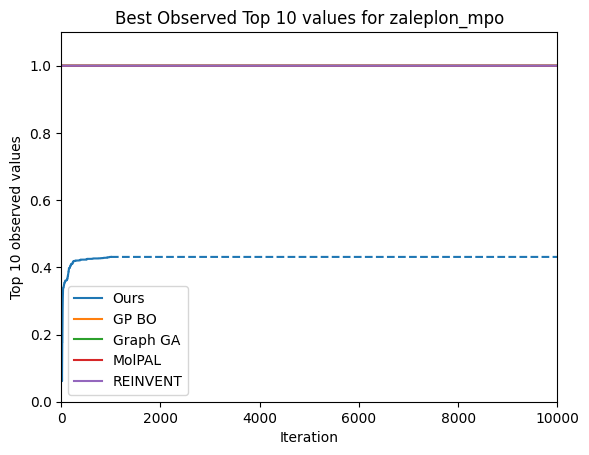

In [6]:
# Define colours for the different plots
sns_colours = get_sns_colors()

# Plot our results
exp_data = prepare_experiment_results(exp_buffer_path, exp_start_iteration)
sns.lineplot(x=list(range(1, len(exp_data)+1)), y=exp_data, label='Ours', color=sns_colours[0])

# Extrapolate our plots to match the number of iterations in PMO
extra_data = [exp_data[-1]] * (n_pmo_iterations - len(exp_data))
sns.lineplot(x=list(range(len(exp_data)+1, n_pmo_iterations+1)), y=extra_data, linestyle='--', color=sns_colours[0])

# Plot the PMO curves 
for i, (label, json_file) in enumerate(pmo_results_map.items()):
    file_path = pmo_results_dir + json_file
    pmo_data = prepare_pmo_results(file_path, smoothing_sigma, pmo_start_iteration)
    sns.lineplot(x=list(range(1, len(pmo_data)+1)), y=pmo_data, label=label, color=sns_colours[i+1])

plt.xlabel("Iteration")
plt.ylabel("Top 10 observed values")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title(title)
plt.legend()

plt.show()
plt.close()
